In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as plt 
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
import tensorflow as tf
import seaborn as sns


In [44]:
def montagem_dataset(timestamp, features, avanco):
  df = pd.read_csv('EURUSD.csv', sep=';', header=0)
  # Escolha de features
  z = df.copy()
  indice_treino = int(len(z)*0.8) + avanco
  
  df_train     = z.iloc[ 0:indice_treino,2:5]
  df_test      = z.iloc[ indice_treino:,2:5]
  df_test_orig = z.iloc[ indice_treino:,0:5]
  
  #Escala nas features
  # from sklearn.preprocessing import MinMaxScaler
  # sc = MinMaxScaler()
  # df_train = sc.fit_transform(df_train)
  #Formação do x_train
  x_train = []
  y_train = []
  length = len(df_train)

  for i in range(timestamp, length):
    x_train.append( df_train.iloc[i-timestamp:i,:].values )
    y_train.append( df_train.iloc[i,features-1] )
  
  print(df_train)
  print("\n")
  print(x_train[0])
  print("\n")
  print(y_train[0])
  print("\n")
  print(df_train)
  print("\n")
  print(x_train[1])
  print("\n")
  print(y_train[1])



  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], timestamp, features))
  return x_train, y_train, df_test, df_test_orig, sc



In [21]:
#Criação da rede neural
def treinamento_rede_neural(timestamp, features,  x_train, y_train, epochs):
  model = None
  model = Sequential()
  model.add(LSTM(units = 120, return_sequences = True, input_shape=( timestamp , features) ) ) 
  model.add(LSTM(units = 120, return_sequences = False)) 
  #model.add(Dropout(0.1))
  #model.add(Dense(units = 1)) 
  #model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  #model.add(LSTM(50, input_shape=(44725, x_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  model.fit(x_train, y_train, epochs = epochs)
  #model.save('drive/My Drive/TCC/modelo/LSTM')
  #import tensorflow as tf
  #model = tf.keras.models.load_model('drive/My Drive/TCC/modelo/LSTM')
  #df_test_close = df_test_close.reshape(-1, 1)
  #df_test = sc.fit_transform(df_test)
  return model

In [22]:
def teste_rede(model, df_test,df_test_orig, sc, janela, shift):
  #Escalando o dataset teste para comparação com as previsões
  # from sklearn.preprocessing import MinMaxScaler
  # sc1 = MinMaxScaler()
  # df_test1 = df_test.copy()
  # df_test1 = sc1.fit_transform(df_test1.iloc[:,features-1].values.reshape(-1,1))
  # df_test = sc.fit_transform(df_test)

  #pegando maximos e minimos para testes com a previsao
  x_test =    []
  y_test =    []
  y_max  =    []
  y_min  =    [] 
  open_test = []
  data_test = []

  length = len(df_test)
  for i in range(timestamp, length):
    x_test.append( df_test[i-timestamp:i,:])
    y_test.append( df_test[i,features-1])
    y_max.append( df_test_orig.iloc[i,3])
    y_min.append( df_test_orig.iloc[i,2])
    open_test.append( df_test_orig.iloc[i-1,4] )
    data_test.append( df_test_orig.iloc[i,0])
  
 
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], timestamp, features))
  

  #Criando variavel Y_pred para receber as previsões
  y_pred = []
  y_pred = model.predict(x_test-shift)

  #Invertendo a escala para valores reais
  # predicted_price = sc1.inverse_transform(y_pred)
  # y_test = sc1.inverse_transform(y_test.reshape(-1,1))

  #Calculos  para previsao
  previsao = pd.DataFrame(data=predicted_price , columns=['Previsão'])
  numero_real = pd.DataFrame(data=y_test , columns=['Fecahmaneto'])
  #y_max_pd = pd.DataFrame(data=y_max, columns=['Máxima'])
  preco_de_abertura = pd.DataFrame(data=open_test , columns=['Abertura'])
  maxima = pd.DataFrame(data=y_max , columns=['Máxima'])
  minima = pd.DataFrame(data=y_min , columns=['Mínima'])
  frames = [ preco_de_abertura, maxima, minima, numero_real, previsao]
  result = pd.concat(frames, axis=1, join='inner')
  
  #Graficos de previsao
  plt.plot(y_test[:janela], color='red', label='Preço Atual das Ações')
  plt.plot(result.index.values[:janela], result.iloc[:janela,4].values , '.')
  plt.fill_between(result.index.values[:janela], result.iloc[:janela,1].values, result.iloc[:janela,2], alpha=0.5)
  plt.title('Previsão de Preço de Ações')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.legend()
  plt.show()


  #####Calculo de acertos da previsao####################
  acumulador = 0
  lucro_prejuizo = []
  resumo_acumulado = []
  acertos = 0
  erros   = 0
  resumo  = []
  portcentagem = 0


  for i in range (0, janela):
      soma = 0
      if predicted_price[i] in pd.Interval(left=y_min[i], right=y_max[i]):
        soma = abs( np.round(predicted_price[i],5) - np.around(open_test[i], 5 ))
        soma = int(soma*100000)
        acertos = acertos + 1
      else:
        if y_test[i] > open_test[i]:
          if predicted_price[i] > open_test[i]:
            soma = abs( np.round(y_test[i], 5) - np.round(open_test[i], 5) )
            soma = int(soma*100000)
            acertos = acertos + 1
          else:
            soma = np.round(open_test[i], 5) - np.round(y_test[i], 5)
            soma = int(soma*100000)
            erros = erros + 1
        else:
          if predicted_price[i] < open_test[i]:
            soma = abs( np.round(y_test[i], 5) - np.round(open_test[i], 5))
            soma = int(soma*100000)
            acertos = acertos + 1
          else:
            soma = np.round(y_test[i], 5) - np.round(open_test[i], 5)
            soma = int(soma*100000)
            erros = erros + 1
      acumulador = acumulador + soma
      resumo_acumulado.append(acumulador)

  portcentagem = acertos*100/janela
  print("Acertos: ", acertos)
  print("Erros: ", erros)
  print("Pontos Ganhos: ", acumulador)
  print("%", portcentagem)
  print("Meses em teste estudados: ", int(len(predicted_price)/janela))
  # resumo = pd.DataFrame(data=lucro_prejuizo , columns=['Resumo'])
  resumo_acumulado = pd.DataFrame(data=resumo_acumulado , columns=['Resumo Acumulado '])
  #return acumulador
  
  previsao = pd.DataFrame(data=predicted_price , columns=['Previsão'])
  numero_real = pd.DataFrame(data=y_test , columns=['Fecahmaneto'])
  #y_max_pd = pd.DataFrame(data=y_max, columns=['Máxima'])
  preco_de_abertura = pd.DataFrame(data=open_test , columns=['Abertura'])
  maxima = pd.DataFrame(data=y_max , columns=['Máxima'])
  minima = pd.DataFrame(data=y_min , columns=['Mínima'])
  frames = [ preco_de_abertura, maxima, minima, numero_real, previsao,resumo_acumulado]
  result = pd.concat(frames, axis=1, join='inner')
  data_test_pd =  pd.DataFrame(data=data_test , columns=['Data'])
  frames_to_csv= [ data_test_pd,maxima, minima, previsao]
  result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
  print(result)

  plt.plot(resumo_acumulado, color='blue', label='Preço Atual das Ações')
  plt.title('Resumo Acumulado')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.legend()
  plt.show()
  plt.title('Preço final')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.plot(y_test, color='red', label='Preço Atual das Ações')
  plt.show()
  return acumulador,portcentagem,result_to_csv

In [23]:
def save_tocsv(result_to_csv):
  result_to_csv.to_csv('previsoes.csv')
  print(result_to_csv)

In [45]:
features = 3
timestamp = 2
epochs = 30
janela = 72
shift  = 0.0000
avanco = 280
x_train = []
y_train = []
x_train = None
y_train = None
(x_train, y_train, df_test, df_test_orig, sc) = montagem_dataset(timestamp, features, avanco)


         high1     low1   close1
0      1.08730  1.08870  1.08800
1      1.08650  1.08800  1.08690
2      1.08620  1.08710  1.08670
3      1.08530  1.08690  1.08590
4      1.08580  1.08640  1.08580
...        ...      ...      ...
25083  1.10675  1.10756  1.10683
25084  1.10662  1.10712  1.10679
25085  1.10679  1.10767  1.10751
25086  1.10751  1.10785  1.10769
25087  1.10723  1.10763  1.10753

[25088 rows x 3 columns]


[[1.0873 1.0887 1.088 ]
 [1.0865 1.088  1.0869]]


1.0867


         high1     low1   close1
0      1.08730  1.08870  1.08800
1      1.08650  1.08800  1.08690
2      1.08620  1.08710  1.08670
3      1.08530  1.08690  1.08590
4      1.08580  1.08640  1.08580
...        ...      ...      ...
25083  1.10675  1.10756  1.10683
25084  1.10662  1.10712  1.10679
25085  1.10679  1.10767  1.10751
25086  1.10751  1.10785  1.10769
25087  1.10723  1.10763  1.10753

[25088 rows x 3 columns]


[[1.0865 1.088  1.0869]
 [1.0862 1.0871 1.0867]]


1.0859


NameError: name 'sc' is not defined

Epoch 1/30
784/784 [==============================] - 19s 24ms/step - loss: 0.0142
Epoch 2/30
784/784 [==============================] - 14s 18ms/step - loss: 0.0054
Epoch 3/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0050
Epoch 4/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0052
Epoch 5/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0052
Epoch 6/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0052
Epoch 7/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0051
Epoch 8/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0046
Epoch 9/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0048
Epoch 10/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0047
Epoch 11/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0047
Epoch 12/30
784/784 [==============================] - 10s 13ms/step - loss: 0.0046
E

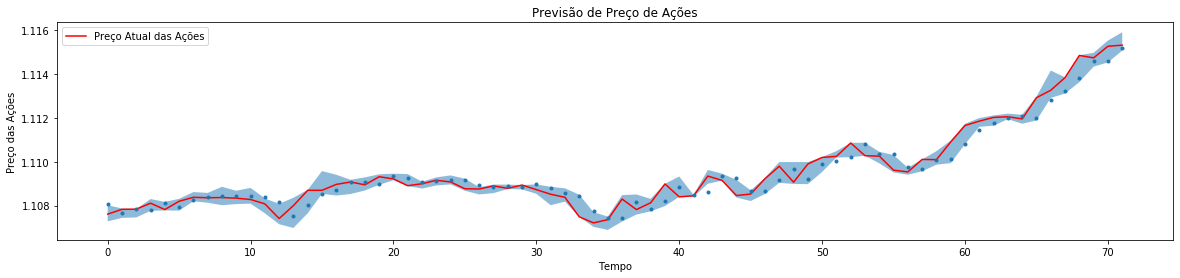

Acertos:  60
Erros:  12
Pontos Ganhos:  109
% 83.33333333333333
Meses em teste estudados:  82
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10802  1.10802  1.10728      1.10761  1.108061                -41
1    1.10761  1.10787  1.10744      1.10783  1.107673                -36
2    1.10783  1.10784  1.10746      1.10784  1.107853                -36
3    1.10784  1.10830  1.10776      1.10811  1.107821                -35
4    1.10811  1.10817  1.10778      1.10782  1.108102                -35
..       ...      ...      ...          ...       ...                ...
67   1.11327  1.11386  1.11312      1.11385  1.113229                 60
68   1.11385  1.11487  1.11364      1.11486  1.113827                 62
69   1.11486  1.11498  1.11435      1.11475  1.114600                 88
70   1.11475  1.11554  1.11454      1.11528  1.114605                102
71   1.11528  1.11592  1.11508      1.11533  1.115201                109

[72 rows x 6 columns]


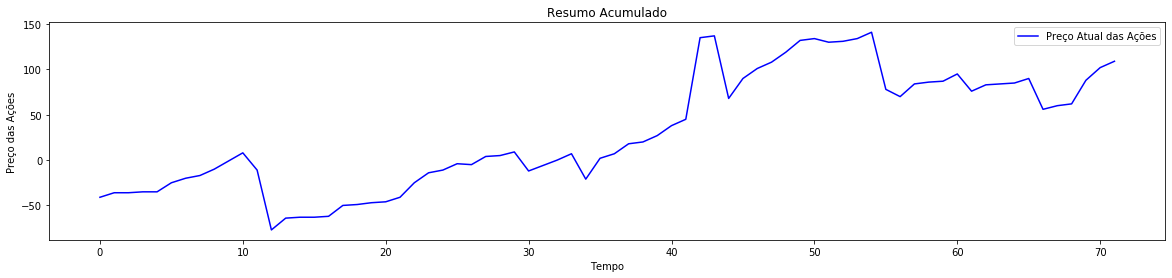

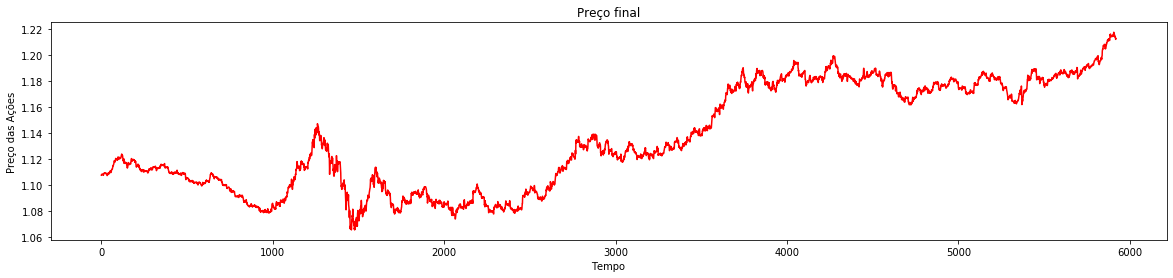

                     Data   Máxima   Mínima  Previsão
0     2019.12.23 02:00:00  1.10802  1.10728  1.108061
1     2019.12.23 03:00:00  1.10787  1.10744  1.107673
2     2019.12.23 04:00:00  1.10784  1.10746  1.107853
3     2019.12.23 05:00:00  1.10830  1.10776  1.107821
4     2019.12.23 06:00:00  1.10817  1.10778  1.108102
...                   ...      ...      ...       ...
5915  2020.12.04 20:00:00  1.21510  1.21404  1.213634
5916  2020.12.04 21:00:00  1.21451  1.21330  1.213684
5917  2020.12.04 22:00:00  1.21397  1.21116  1.213334
5918  2020.12.04 23:00:00  1.21293  1.21092  1.212298
5919  2020.12.07 00:00:00  1.21293  1.21161  1.211467

[5920 rows x 4 columns]
109 83.33333333333333


In [52]:
maior_ponto   =  0
rotacao       =  0
maior_acerto      =  0

#for epochs in range(30,50):
for i in range(1):
   model = treinamento_rede_neural(timestamp, features, x_train, y_train, epochs)
   pontos,acerto,data_test = teste_rede(model ,df_test, df_test_orig, sc, janela, shift )
   if acerto > maior_acerto:
     if pontos > maior_ponto:
       #model.save('drive/My Drive/TCC/modelo/LSTM')
       save_tocsv(data_test)
       maior_ponto = pontos
       maior_acerto = acerto

print(maior_ponto, maior_acerto)